# <center> NIRS Project </center>


<!---  <h2 align="center"; color:#000080> 
denter
</h2> --->


## <h1 align="center">   I. Summary </h1>

### Preface
This was one of my earliest DNN builds I did a few years ago. I added it to show the basic overall approach to solving the goal I had. The code is likely dated by now with some deprecation but feel free to have a look. 

### Project Overview
The goal of this project was to create a classifier that could take raw Near-Infrared Spectroscopy (NIRS) data and accurately predict heart rate (HR) in beats / minute (bpm). To do this, I recorded the raw NIRS data from an small portable fitness device and combined it with recorded HR data from a chest strap used by athletes.  

So for this project, our labeled data was HR from the chest strap and our predictor data was on NIRS measurements. 

Several machine learning techniques were explored along with a basic recurrent neural network (RNN). 

#### Note:
The end result was ultimately poor and further methods such as long-short term neural networks (LSTM's) and gated recurrent units (GRU) were not explored as the source of the data was discovered to be uable to match up at time points to accurately sync together. This was likely due to the different software used to record each signal. However, the process for exploring the data and training the classifiers can still be of some use.  

### Metrics
There are two metrics that will were used for this project:
> 1. Optical Light Data
> 2. Heart Rate Data

The optical light data collected from the NIRS device is extracted by sending light from the device into the user, then measuring light reflected back, calculating the light absorbed by the tissue. Many biological metabolites and molecules respond to wavelengths in the near-infrared light spectrum, thus making this technology particular important for use in collecting information about the body.  Values are recorded as integers which indicate the relative amount of absorption. This data is transmitted every 0.5 seconds and gives values for 4 different spectrums of light. Therefore, for every half second, 8 different data points are collected. 

Two different types of software were used to collect data. The first collected the data for just the NIRS sensor, giving both the raw data values, along with the intended measurements of the device - muscle oxygenation (SmO2). The second piece of software collected both the SmO2 values from the NIRS device as well as the HR from the chest strap, athough not the raw NIRS data. The data from this software was used to sync the raw NIRS data with the HR data, but as already mentioned, the synchronization was not able to be done accurately, presumably do to different SmO2 measurements collected from the two different softwares. This could be do to how each upsampled the measurement to 0.5s from the much higher sampling rate performed by the device when collecting raw NIRS measurements. 


In [ ]:
""" This notebook was constructed to use Python 3.5 """

# import all neccessary libraries 
import numpy as np
import pandas as pd
# import renders as rs


# data visualization tools
import seaborn as sns
import matplotlib.pyplot as plt
import visuals as vs 

from IPython.display import display

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

from sklearn import svm, datasets, tree
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, fbeta_score, make_scorer, f1_score
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from time import time

from collections import defaultdict


In [2]:
from __future__ import print_function

# load the CSV files dataset
try:
    peri_data_1 = pd.read_csv('Levi_peri_test.csv')
    peri_data_2 = pd.read_csv('Mae_peri_test.csv')
    raw_data_1 = pd.read_csv('Levi_raw_.csv')
    raw_data_2 = pd.read_csv('Mae_raw_.csv')
except:
    print ("Dataset could not be loaded. Is the dataset missing?")

print ("Data read successfully!")

# Print the first few entries of CSV's
print ('1')
display(raw_data_1.head())
display(peri_data_1.head())

print('2')
display(raw_data_2.head(n=5))
display(peri_data_2.head(n=5))

print ('___________________________________')
print('')
print ('New Dataframes')
# Remove all of the unnecessary features
new_raw_1 = raw_data_1
new_raw_1.drop(['yyyy.mm.dd', 'Unnamed: 15', 'Unnamed: 16', 'Temp'], axis = 1, inplace=True)

new_peri_1 = peri_data_1
new_peri_1.drop(['mm-dd', 'Target Power', 'Speed', 'Power', 'Lap', 'Cadence'], axis = 1, inplace=True)

new_raw_2 = raw_data_2
new_raw_2.drop(['yyyy.mm.dd', 'Unnamed: 15', 'Temp'], axis = 1, inplace=True)

new_peri_2 = peri_data_2
new_peri_2.drop(['mm-dd', 'Target Power', 'Speed', 'Power', 'Lap', 'Cadence'], axis = 1, inplace=True)

print ('1')
display(new_raw_1.head(n=5))
display(new_raw_1.describe())
display(new_peri_1.head(n=5))
display(new_peri_1.describe())

print ('2')
display(new_raw_2.head(n=5))
display(new_peri_2.head(n=5))


Data read successfully!
1


,yyyy.mm.dd,hh:mm:ss,SmO2 Live,SmO2 Averaged,s680,s720,s760,s800,l680,l720,l760,l800,Good,Temp,THb,Unnamed: 15,Unnamed: 16
0,2016.10.27,20:56:43,80.0,80.0,1842372.0,3433461.0,3035776.0,4354345.0,136292.0,278251.0,222780.0,317085.0,20.0,713.0,12.38,6.0,NaN
1,2016.10.27,20:56:43,80.0,80.0,1835872.0,3420182.0,3020543.0,4330833.0,134810.0,276001.0,221433.0,313725.0,20.0,713.0,12.43,6.0,NaN
2,2016.10.27,20:56:44,80.0,80.0,1839622.0,3428461.0,3030196.0,4349293.0,136665.0,278728.0,223080.0,316905.0,20.0,713.0,12.39,6.0,NaN
3,2016.10.27,20:56:44,80.0,80.0,1836259.0,3421972.0,3023095.0,4333888.0,135711.0,277520.0,222095.0,314815.0,20.0,713.0,12.42,6.0,NaN
4,2016.10.27,20:56:45,81.0,81.0,1836027.0,3419434.0,3019762.0,4329108.0,136325.0,277840.0,221934.0,314208.0,20.0,713.0,12.41,6.0,NaN


,mm-dd,hh:mm:ss,SmO2 Live,SmO2 Averaged,THb,Lap,Target Power,Heart Rate,RR Heart Rate,Speed,Power,Cadence
0,1-Jan,0:00:00,0,0,0.00,0,0,0,0.000000,0,0,0
1,Jan-00,0:00:01,0,81,12.35,0,0,75,75.018315,0,0,0
2,Jan-00,0:00:01,0,81,12.35,0,0,75,75.018315,0,0,0
3,Jan-00,0:00:02,0,81,12.39,0,0,75,75.018315,0,0,0
4,Jan-00,0:00:02,0,81,12.39,0,0,75,75.018315,0,0,0


2


,yyyy.mm.dd,hh:mm:ss,SmO2 Live,SmO2 Averaged,s680,s720,s760,s800,l680,l720,l760,l800,Good,Temp,THb,Unnamed: 15
0,2016.10.28,2:53:38,81.0,81.0,2429896.0,4508569.0,3908478.0,5720432.0,470717.0,894550.0,703861.0,1051111.0,19.0,720.0,11.47,4.0
1,2016.10.28,2:53:38,83.0,83.0,2555574.0,4740368.0,4109880.0,6021743.0,495871.0,940702.0,740383.0,1106141.0,20.0,720.0,11.45,4.0
2,2016.10.28,2:53:39,81.0,81.0,2555514.0,4741014.0,4110097.0,6021093.0,494950.0,939817.0,739364.0,1104789.0,20.0,720.0,11.47,4.0
3,2016.10.28,2:53:39,81.0,81.0,2557737.0,4743621.0,4113265.0,6028537.0,495914.0,941496.0,740031.0,1106472.0,20.0,720.0,11.47,4.0
4,2016.10.28,2:53:40,81.0,81.0,2557914.0,4741794.0,4111834.0,6026836.0,494431.0,938790.0,739019.0,1105016.0,20.0,720.0,11.48,4.0


,mm-dd,hh:mm:ss,SmO2 Live,SmO2 Averaged,THb,Lap,Target Power,Heart Rate,RR Heart Rate,Speed,Power,Cadence
0,1-Jan,0:00:00,0,0,0.00,0,0,0,0.000000,0,0,0
1,Jan-00,0:00:01,0,84,11.42,0,0,0,0.000000,0,0,0
2,Jan-00,0:00:01,0,84,11.42,0,0,55,55.004476,0,0,0
3,Jan-00,0:00:02,0,84,11.42,0,0,55,55.004476,0,0,0
4,Jan-00,0:00:02,0,84,11.42,0,0,55,55.004476,0,0,0


___________________________________

New Dataframes
1


,hh:mm:ss,SmO2 Live,SmO2 Averaged,s680,s720,s760,s800,l680,l720,l760,l800,Good,THb
0,20:56:43,80.0,80.0,1842372.0,3433461.0,3035776.0,4354345.0,136292.0,278251.0,222780.0,317085.0,20.0,12.38
1,20:56:43,80.0,80.0,1835872.0,3420182.0,3020543.0,4330833.0,134810.0,276001.0,221433.0,313725.0,20.0,12.43
2,20:56:44,80.0,80.0,1839622.0,3428461.0,3030196.0,4349293.0,136665.0,278728.0,223080.0,316905.0,20.0,12.39
3,20:56:44,80.0,80.0,1836259.0,3421972.0,3023095.0,4333888.0,135711.0,277520.0,222095.0,314815.0,20.0,12.42
4,20:56:45,81.0,81.0,1836027.0,3419434.0,3019762.0,4329108.0,136325.0,277840.0,221934.0,314208.0,20.0,12.41


C:\Users\LeviZ\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,SmO2 Live,SmO2 Averaged,s680,s720,s760,s800,l680,l720,l760,l800,Good,THb
count,3.180000e+03,3.180000e+03,3.177000e+03,3.173000e+03,3.172000e+03,3.170000e+03,3167.000000,3163.000000,3163.000000,3162.000000,3162.000000,3162.000000
mean,1.441207e+03,2.765943e+03,1.885443e+06,3.544064e+06,3.121952e+06,4.424280e+06,137780.696558,278912.556538,221748.510275,309242.919671,19.986401,12.379475
std,7.308086e+04,1.440397e+05,1.738596e+05,3.210437e+05,2.924992e+05,4.467044e+05,11478.600753,18396.707019,14288.570440,20337.472184,0.115837,0.088686
min,6.100000e+01,8.000000e+00,1.000000e+00,2.000000e+01,1.239000e+01,5.000000e+00,6.000000,12.330000,6.000000,273253.000000,19.000000,12.090000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,4.116211e+06,8.116654e+06,2.251951e+06,4.253870e+06,3.784068e+06,5.428220e+06,175336.000000,340911.000000,271134.000000,385255.000000,20.000000,12.670000


,hh:mm:ss,SmO2 Live,SmO2 Averaged,THb,Heart Rate,RR Heart Rate
0,0:00:00,0,0,0.00,0,0.000000
1,0:00:01,0,81,12.35,75,75.018315
2,0:00:01,0,81,12.35,75,75.018315
3,0:00:02,0,81,12.39,75,75.018315
4,0:00:02,0,81,12.39,75,75.018315


,SmO2 Live,SmO2 Averaged,THb,Heart Rate,RR Heart Rate
count,3590.0,3590.000000,3590.000000,3590.000000,3590.000000
mean,0.0,84.399721,12.390217,46.101671,46.092635
std,0.0,4.171758,0.471562,36.782841,36.810833
min,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.0,83.000000,12.350000,0.000000,0.000000
50%,0.0,85.000000,12.410000,71.000000,71.028902
75%,0.0,86.000000,12.470000,76.000000,76.039604
max,0.0,90.000000,12.670000,92.000000,92.113943


2


,hh:mm:ss,SmO2 Live,SmO2 Averaged,s680,s720,s760,s800,l680,l720,l760,l800,Good,THb
0,2:53:38,81.0,81.0,2429896.0,4508569.0,3908478.0,5720432.0,470717.0,894550.0,703861.0,1051111.0,19.0,11.47
1,2:53:38,83.0,83.0,2555574.0,4740368.0,4109880.0,6021743.0,495871.0,940702.0,740383.0,1106141.0,20.0,11.45
2,2:53:39,81.0,81.0,2555514.0,4741014.0,4110097.0,6021093.0,494950.0,939817.0,739364.0,1104789.0,20.0,11.47
3,2:53:39,81.0,81.0,2557737.0,4743621.0,4113265.0,6028537.0,495914.0,941496.0,740031.0,1106472.0,20.0,11.47
4,2:53:40,81.0,81.0,2557914.0,4741794.0,4111834.0,6026836.0,494431.0,938790.0,739019.0,1105016.0,20.0,11.48


,hh:mm:ss,SmO2 Live,SmO2 Averaged,THb,Heart Rate,RR Heart Rate
0,0:00:00,0,0,0.00,0,0.000000
1,0:00:01,0,84,11.42,0,0.000000
2,0:00:01,0,84,11.42,55,55.004476
3,0:00:02,0,84,11.42,55,55.004476
4,0:00:02,0,84,11.42,55,55.004476


## <h1 align="center">   II. Analysis </h1>

### Data Exploration
The datasets used in this project consist of four different CSV files. These were uploaded using Pandas, then the head of each was printed to show the columns, features, and data types contained within the files. Next, columns with data that was determined to be either redundant or not of any significant importance was dropped. This was determined from the combination of a scatter matrix, heatmap, and domain knowledge.  


### Exploratory Visualization
Besides the printing of the Dataframe itself, a heatmap and scattermatrix were made using matplotlib. This helped to parse the data as described previously. These visualizations show what types of information, whether there were any non-zero values, and what the correlation to the dependent variable (heart rate) are. 


### Algorithms and Techniques
It was decided to test a few different models. Taking a supervised learning approach,  GuassianNB and SVC where performed. Cross-validation and GridSearch were used to properly train the models. Variance, Bias, and F Score were used to access the performance of each model. The parameters are shown in the code within the notebook. 

Next a Decision Tree Regressor and PCA were performed. The PCA revealed that the set for 2 clusters had the highest Silhouette score in a K Means. 


### Benchmark
The benchmark threshold for this project was set at 85%. This was determined from searching for the relative accuracy rates for wrist-based optical heart rate sensors available for consumers. From the specific article cited here, the lowest accuracy for a similar heart rate range from the input data used, was set as the threshold. The error percentage for one watch was roughly 10% so our benchmark was set at 150% of this - 15%. Ideally, this benchmark will be surpassed despite lacking the team of professionals these companies. 

https://www.cnet.com/news/how-accurate-are-wristband-heart-rate-monitors/


To improve predictability, and for fun, using a RNN with Tensorflow was performed. 


In [33]:
"""Sync Time Data by matching values and subtracting the time difference - (found manually in the CSV file where the 
# SmO2 & THb values matched up in the different CSV files for each subject)

# Data set 1: subtract - 20:56:27 - 37, 68
# Data set 2: subtract 2:53:23 - 2211, 1607
"""
#pd.DatetimeIndex(new_raw_2['hh:mm:ss']) + pd.DateOffset(1)

from datetime import datetime , timedelta

# copy data then convert time stamp row to timedelta
new_new_raw_1 = new_raw_1
new_new_raw_2 = new_raw_2

new_new_peri_1 = new_peri_1
new_new_peri_2 = new_peri_2

# convert time stamp row to timedelta
# pd.to_timedelta(new_peri_1['hh:mm:ss'], unit = 'ms')
# pd.to_timedelta(new_peri_2['hh:mm:ss'], unit = 'ms')

# add 'shift' column time feature so SmO2 values match up to sync time recordings 
new_new_raw_1['shift'] = ((pd.to_timedelta(new_new_raw_1['hh:mm:ss'])) - pd.to_timedelta('20:56:27'))
new_new_raw_2['shift'] = ((pd.to_timedelta(new_new_raw_2['hh:mm:ss'])) - pd.to_timedelta('02:53:23'))


# remove rows that don't have complete datafields
new_new_raw_1.dropna(how='any')
new_new_raw_2.dropna(how='any')

new_new_peri_1.dropna(how='any')
new_new_peri_2.dropna(how='any')

# remove hh:mm:ss rows that don't have another matching row
# new_new_raw_1.ix[new_new_raw_1['SmO2 Averaged'] != 0]
# new_new_raw_2.ix[new_new_raw_2['SmO2 Averaged'] != 0]
# new_new_peri_1.ix[new_new_peri_1['RR Heart Rate'] != 0]
# new_new_peri_2.ix[new_new_peri_2['RR Heart Rate'] != 0]
# new_new_peri_1.ix[new_new_peri_1['Heart Rate'] != 0]
# new_new_peri_2.ix[new_new_peri_2['Heart Rate'] != 0]
new_new_raw_1 = new_new_raw_1[new_new_raw_1['SmO2 Averaged'] != 0]
new_new_raw_2 = new_new_raw_2[new_new_raw_2['SmO2 Averaged'] != 0]
new_new_peri_1 = new_new_peri_1[new_new_peri_1['RR Heart Rate'] != 0]
new_new_peri_2 = new_new_peri_2[new_new_peri_2['RR Heart Rate'] != 0]
new_new_peri_1 = new_new_peri_1[new_new_peri_1['Heart Rate'] != 0]
new_new_peri_2 = new_new_peri_2[new_new_peri_2['Heart Rate'] != 0]
# df = df[df.line_race != 0]

# # remove rows that have a dropout - heartrate = 0 or SmO2 = 0


# df = df.drop(df[df.score < 50].index)
# newest_raw_1 = new_new_raw_1.filter(df.count['hh:mm:ss'] < 2).drop().collect()
newest_raw_1 = new_new_raw_1.groupby("hh:mm:ss").filter(lambda x: 3 > len(x) > 1)
newest_raw_2 = new_new_raw_2.groupby("hh:mm:ss").filter(lambda x: 3 > len(x) > 1)

newest_peri_1 = new_new_peri_1.groupby('hh:mm:ss').filter(lambda x: 3 > len(x) > 1)
newest_peri_2 = new_new_peri_2.groupby("hh:mm:ss").filter(lambda x: 3 > len(x) > 1)


# reorder time series to ascending order (I don't know how the order was saved wrong!?)
newest_raw_1.sort_values(['hh:mm:ss'], ascending=True)
newest_raw_2.sort_values(['hh:mm:ss'], ascending=True)

newest_peri_1.sort_values(['hh:mm:ss'], ascending=True)
newest_peri_2.sort_values(['hh:mm:ss'], ascending=True)

# add 0.5 seconds to the 2nd hh:mm:ss value that occurs in a column
newest_raw_1.ix[1::2, 'shift'] += pd.to_timedelta('00:00:00.5')
newest_raw_2.ix[1::2, 'shift'] += pd.to_timedelta('00:00:00.5')

newest_peri_1['hh:mm:ss'] = (pd.to_timedelta(newest_peri_1['hh:mm:ss'], unit='ms'))
newest_peri_2['hh:mm:ss'] = (pd.to_timedelta(newest_peri_2['hh:mm:ss'], unit='ms'))
print (newest_peri_1.dtypes)

newest_peri_1.ix[2::2, 'hh:mm:ss'] += pd.to_timedelta('00:00:00.5', unit='ms')
newest_peri_2.ix[2::2, 'hh:mm:ss'] += pd.to_timedelta('00:00:00.5', unit='ms')

print ('newest')
display(newest_raw_1)
display(newest_raw_2)

display(newest_peri_1)
display(newest_peri_2)

# newest_raw_1.loc[newest_raw_1['hh:mm:ss'] == '21:49:00']

C:\Users\LeviZ\Anaconda3\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\LeviZ\Anaconda3\lib\site-packages\ipykernel\__main__.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\LeviZ\Anaconda3\lib\site-packages\ipykernel\__main__.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

hh:mm:ss         timedelta64[ns]
SmO2 Live                  int64
SmO2 Averaged              int64
THb                      float64
Heart Rate                 int64
RR Heart Rate            float64
dtype: object
newest


,hh:mm:ss,SmO2 Live,SmO2 Averaged,s680,s720,s760,s800,l680,l720,l760,l800,Good,THb,shift
0,20:56:43,80.0,80.0,1842372.0,3433461.0,3035776.0,4354345.0,136292.0,278251.0,222780.0,317085.0,20.0,12.38,00:00:16
1,20:56:43,80.0,80.0,1835872.0,3420182.0,3020543.0,4330833.0,134810.0,276001.0,221433.0,313725.0,20.0,12.43,00:00:16.500000
2,20:56:44,80.0,80.0,1839622.0,3428461.0,3030196.0,4349293.0,136665.0,278728.0,223080.0,316905.0,20.0,12.39,00:00:17
3,20:56:44,80.0,80.0,1836259.0,3421972.0,3023095.0,4333888.0,135711.0,277520.0,222095.0,314815.0,20.0,12.42,00:00:17.500000
4,20:56:45,81.0,81.0,1836027.0,3419434.0,3019762.0,4329108.0,136325.0,277840.0,221934.0,314208.0,20.0,12.41,00:00:18
5,20:56:45,81.0,81.0,1836027.0,3419434.0,3019762.0,4329108.0,136325.0,277840.0,221934.0,314208.0,20.0,12.41,00:00:18.500000
6,20:56:46,81.0,81.0,1836971.0,3420894.0,3022338.0,4332646.0,135937.0,278043.0,222689.0,315098.0,20.0,12.44,00:00:19
7,20:56:46,82.0,82.0,1830167.0,3410449.0,3010144.0,4312325.0,134556.0,275786.0,221509.0,311171.0,20.0,12.50,00:00:19.500000
8,20:56:47,81.0,81.0,1740933.0,3242003.0,2861273.0,4100410.0,129347.0,262913.0,209913.0,297290.0,19.0,12.39,00:00:20
9,20:56:47,80.0,80.0,1826842.0,3402957.0,3001790.0,4297710.0,134758.0,274327.0,218360.0,309755.0,20.0,12.38,00:00:20.500000


,hh:mm:ss,SmO2 Live,SmO2 Averaged,s680,s720,s760,s800,l680,l720,l760,l800,Good,THb,shift
0,2:53:38,81.0,81.0,2429896.0,4508569.0,3908478.0,5720432.0,470717.0,894550.0,703861.0,1051111.0,19.0,11.47,00:00:15
1,2:53:38,83.0,83.0,2555574.0,4740368.0,4109880.0,6021743.0,495871.0,940702.0,740383.0,1106141.0,20.0,11.45,00:00:15.500000
2,2:53:39,81.0,81.0,2555514.0,4741014.0,4110097.0,6021093.0,494950.0,939817.0,739364.0,1104789.0,20.0,11.47,00:00:16
3,2:53:39,81.0,81.0,2557737.0,4743621.0,4113265.0,6028537.0,495914.0,941496.0,740031.0,1106472.0,20.0,11.47,00:00:16.500000
4,2:53:40,81.0,81.0,2557914.0,4741794.0,4111834.0,6026836.0,494431.0,938790.0,739019.0,1105016.0,20.0,11.48,00:00:17
5,2:53:40,81.0,81.0,2559229.0,4745830.0,4115786.0,6032779.0,495681.0,940409.0,740376.0,1107769.0,20.0,11.45,00:00:17.500000
6,2:53:41,81.0,81.0,2557706.0,4743181.0,4113190.0,6029087.0,494934.0,939248.0,739332.0,1106034.0,20.0,11.46,00:00:18
7,2:53:41,81.0,81.0,2557975.0,4745497.0,4117095.0,6035217.0,495047.0,940308.0,740625.0,1107384.0,20.0,11.47,00:00:18.500000
8,2:53:42,81.0,81.0,2558193.0,4744470.0,4115930.0,6032603.0,494049.0,939404.0,740220.0,1105367.0,20.0,11.51,00:00:19
9,2:53:42,81.0,81.0,2559583.0,4747438.0,4119663.0,6040561.0,494866.0,940743.0,741610.0,1108901.0,20.0,11.49,00:00:19.500000


,hh:mm:ss,SmO2 Live,SmO2 Averaged,THb,Heart Rate,RR Heart Rate
1,00:00:01,0,81,12.35,75,75.018315
2,00:00:01.500000,0,81,12.35,75,75.018315
7,00:00:04,0,82,12.39,74,74.024096
8,00:00:04.500000,0,82,12.39,74,74.024096
13,00:00:07,0,83,12.44,73,73.055886
14,00:00:07.500000,0,83,12.44,73,73.055886
15,00:00:08,0,83,12.44,72,72.028136
16,00:00:08.500000,0,83,12.44,72,72.028136
17,00:00:09,0,83,12.44,72,72.028136
18,00:00:09.500000,0,83,12.44,72,72.028136


,hh:mm:ss,SmO2 Live,SmO2 Averaged,THb,Heart Rate,RR Heart Rate
7,00:00:04.500000,0,83,11.41,55,55.004476
8,00:00:04,0,83,11.41,56,56.007293
13,00:00:07.500000,0,84,11.42,56,56.007293
14,00:00:07,0,84,11.42,56,56.007293
15,00:00:08.500000,0,84,11.41,56,56.007293
16,00:00:08,0,84,11.41,56,56.007293
17,00:00:09.500000,0,83,11.45,57,57.047354
18,00:00:09,0,83,11.45,57,57.047354
19,00:00:10.500000,0,84,11.42,57,57.047354
20,00:00:10,0,84,11.42,57,57.047354


In [34]:
# Add columns that calculate SmCO2, Oxygenated (O2Hb) and deogenated (HHb) Hemoglobin Values, O2Hb:HHb, and normalized O2Hb:HHb values
newest_raw_1['SmHHb'] = (100 - new_new_raw_1['SmO2 Averaged'])
newest_raw_1['HHb'] = ((newest_raw_1['SmHHb']*newest_raw_1['THb'])/100)
newest_raw_1['O2Hb'] = ((newest_raw_1['SmO2 Averaged']*newest_raw_1['THb'])/100)
newest_raw_1['O2:HHb'] = (newest_raw_1['SmO2 Averaged'] / newest_raw_1['SmHHb'])
newest_raw_1['Normalized_O2_HHb'] = (newest_raw_1['O2:HHb']- np.min(newest_raw_1['O2:HHb']))\
                                    /(np.max(newest_raw_1['O2:HHb']) - np.min(newest_raw_1['O2:HHb']))
print ('raw 1')
display(newest_raw_1.head(n=5))

newest_raw_2['SmHHb'] = (100 - new_new_raw_2['SmO2 Averaged'])
newest_raw_2['HHb'] = ((newest_raw_2['SmHHb']*newest_raw_2['THb'])/100)
newest_raw_2['O2Hb'] = ((newest_raw_2['SmO2 Averaged']*newest_raw_2['THb'])/100)
newest_raw_2['O2:HHb'] = (newest_raw_2['SmO2 Averaged'] / newest_raw_2['SmHHb'])
newest_raw_2['Normalized_O2_HHb'] = (newest_raw_2['O2:HHb']- np.min(newest_raw_2['O2:HHb']))\
                                    /(np.max(newest_raw_2['O2:HHb']) - np.min(newest_raw_2['O2:HHb']))
print ('raw 2')
display(newest_raw_2.head(n=5))
# ?Add columns that calculate delta values - b/w wavelengths, SmCO2, O2Hb, HHb, O2Hb:HHb, normO2Hb:HHb in the same time step, b/w time steps


C:\Users\LeviZ\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\LeviZ\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\LeviZ\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

raw 1


C:\Users\LeviZ\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,hh:mm:ss,SmO2 Live,SmO2 Averaged,s680,s720,s760,s800,l680,l720,l760,l800,Good,THb,shift,SmHHb,HHb,O2Hb,O2:HHb,Normalized_O2_HHb
0,20:56:43,80.0,80.0,1842372.0,3433461.0,3035776.0,4354345.0,136292.0,278251.0,222780.0,317085.0,20.0,12.38,00:00:16,20.0,2.4760,9.9040,4.000000,0.439024
1,20:56:43,80.0,80.0,1835872.0,3420182.0,3020543.0,4330833.0,134810.0,276001.0,221433.0,313725.0,20.0,12.43,00:00:16.500000,20.0,2.4860,9.9440,4.000000,0.439024
2,20:56:44,80.0,80.0,1839622.0,3428461.0,3030196.0,4349293.0,136665.0,278728.0,223080.0,316905.0,20.0,12.39,00:00:17,20.0,2.4780,9.9120,4.000000,0.439024
3,20:56:44,80.0,80.0,1836259.0,3421972.0,3023095.0,4333888.0,135711.0,277520.0,222095.0,314815.0,20.0,12.42,00:00:17.500000,20.0,2.4840,9.9360,4.000000,0.439024
4,20:56:45,81.0,81.0,1836027.0,3419434.0,3019762.0,4329108.0,136325.0,277840.0,221934.0,314208.0,20.0,12.41,00:00:18,19.0,2.3579,10.0521,4.263158,0.468549


C:\Users\LeviZ\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\LeviZ\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\LeviZ\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

raw 2


C:\Users\LeviZ\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\LeviZ\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,hh:mm:ss,SmO2 Live,SmO2 Averaged,s680,s720,s760,s800,l680,l720,l760,l800,Good,THb,shift,SmHHb,HHb,O2Hb,O2:HHb,Normalized_O2_HHb
0,2:53:38,81.0,81.0,2429896.0,4508569.0,3908478.0,5720432.0,470717.0,894550.0,703861.0,1051111.0,19.0,11.47,00:00:15,19.0,2.1793,9.2907,4.263158,0.017544
1,2:53:38,83.0,83.0,2555574.0,4740368.0,4109880.0,6021743.0,495871.0,940702.0,740383.0,1106141.0,20.0,11.45,00:00:15.500000,17.0,1.9465,9.5035,4.882353,0.058824
2,2:53:39,81.0,81.0,2555514.0,4741014.0,4110097.0,6021093.0,494950.0,939817.0,739364.0,1104789.0,20.0,11.47,00:00:16,19.0,2.1793,9.2907,4.263158,0.017544
3,2:53:39,81.0,81.0,2557737.0,4743621.0,4113265.0,6028537.0,495914.0,941496.0,740031.0,1106472.0,20.0,11.47,00:00:16.500000,19.0,2.1793,9.2907,4.263158,0.017544
4,2:53:40,81.0,81.0,2557914.0,4741794.0,4111834.0,6026836.0,494431.0,938790.0,739019.0,1105016.0,20.0,11.48,00:00:17,19.0,2.1812,9.2988,4.263158,0.017544


In [35]:
# combine CSV's data for each person, syncing time series
merged_inner_1 = pd.merge(left = newest_raw_1,right = newest_peri_1, how='inner', left_on='shift', right_on='hh:mm:ss')
merged_inner_1.shape
print ("1:")
print (merged_inner_1.head())

merged_inner_2 = pd.merge(left = newest_raw_2,right = newest_peri_2, how='inner', left_on='shift', right_on='hh:mm:ss')
merged_inner_2.shape
print ("")
print ("2:")
print (merged_inner_2.head())


1:
  hh:mm:ss_x  SmO2 Live_x  SmO2 Averaged_x       s680       s720       s760  \
0   20:56:43         80.0             80.0  1842372.0  3433461.0  3035776.0   
1   20:56:43         80.0             80.0  1835872.0  3420182.0  3020543.0   
2   20:56:44         80.0             80.0  1839622.0  3428461.0  3030196.0   
3   20:56:44         80.0             80.0  1836259.0  3421972.0  3023095.0   
4   20:56:45         81.0             81.0  1836027.0  3419434.0  3019762.0   

        s800      l680      l720      l760      ...           HHb     O2Hb  \
0  4354345.0  136292.0  278251.0  222780.0      ...        2.4760   9.9040   
1  4330833.0  134810.0  276001.0  221433.0      ...        2.4860   9.9440   
2  4349293.0  136665.0  278728.0  223080.0      ...        2.4780   9.9120   
3  4333888.0  135711.0  277520.0  222095.0      ...        2.4840   9.9360   
4  4329108.0  136325.0  277840.0  221934.0      ...        2.3579  10.0521   

     O2:HHb  Normalized_O2_HHb      hh:mm:ss_y  SmO2 

In [36]:
# All column features
print ("All columns 1: \n{}".format(list(merged_inner_1.columns[0:])))
print ("\nAll columns 2: \n{}".format(list(merged_inner_2.columns[0:])))

All columns 1: 
['hh:mm:ss_x', 'SmO2 Live_x', 'SmO2 Averaged_x', 's680', 's720', 's760', 's800', 'l680', 'l720', 'l760', 'l800', 'Good', 'THb_x', 'shift', 'SmHHb', 'HHb', 'O2Hb', 'O2:HHb', 'Normalized_O2_HHb', 'hh:mm:ss_y', 'SmO2 Live_y', 'SmO2 Averaged_y', 'THb_y', 'Heart Rate', 'RR Heart Rate']

All columns 2: 
['hh:mm:ss_x', 'SmO2 Live_x', 'SmO2 Averaged_x', 's680', 's720', 's760', 's800', 'l680', 'l720', 'l760', 'l800', 'Good', 'THb_x', 'shift', 'SmHHb', 'HHb', 'O2Hb', 'O2:HHb', 'Normalized_O2_HHb', 'hh:mm:ss_y', 'SmO2 Live_y', 'SmO2 Averaged_y', 'THb_y', 'Heart Rate', 'RR Heart Rate']


In [37]:
# copy (to prevent altering parent df) & remove all the last unnecessary columns
merged_new_1 = merged_inner_1.copy()
merged_new_1.drop(['SmO2 Live_x', 'Good', 'hh:mm:ss_y', 'SmO2 Live_y', 'hh:mm:ss_x'], axis = 1, inplace=True)

merged_new_2 = merged_inner_2.copy()
merged_new_2.drop(['SmO2 Live_x', 'Good', 'hh:mm:ss_y', 'SmO2 Live_y',  'hh:mm:ss_x'], axis = 1, inplace=True)


# All column features
print ("All columns 1: \n{}".format(list(merged_new_1.columns[0:])))
print ("\nAll columns 2: \n{}".format(list(merged_new_2.columns[0:])))

All columns 1: 
['SmO2 Averaged_x', 's680', 's720', 's760', 's800', 'l680', 'l720', 'l760', 'l800', 'THb_x', 'shift', 'SmHHb', 'HHb', 'O2Hb', 'O2:HHb', 'Normalized_O2_HHb', 'SmO2 Averaged_y', 'THb_y', 'Heart Rate', 'RR Heart Rate']

All columns 2: 
['SmO2 Averaged_x', 's680', 's720', 's760', 's800', 'l680', 'l720', 'l760', 'l800', 'THb_x', 'shift', 'SmHHb', 'HHb', 'O2Hb', 'O2:HHb', 'Normalized_O2_HHb', 'SmO2 Averaged_y', 'THb_y', 'Heart Rate', 'RR Heart Rate']


In [38]:
# merge both csv datasets
vertical_stack = pd.concat([merged_new_1, merged_new_2], axis=0)
# vertical_stack

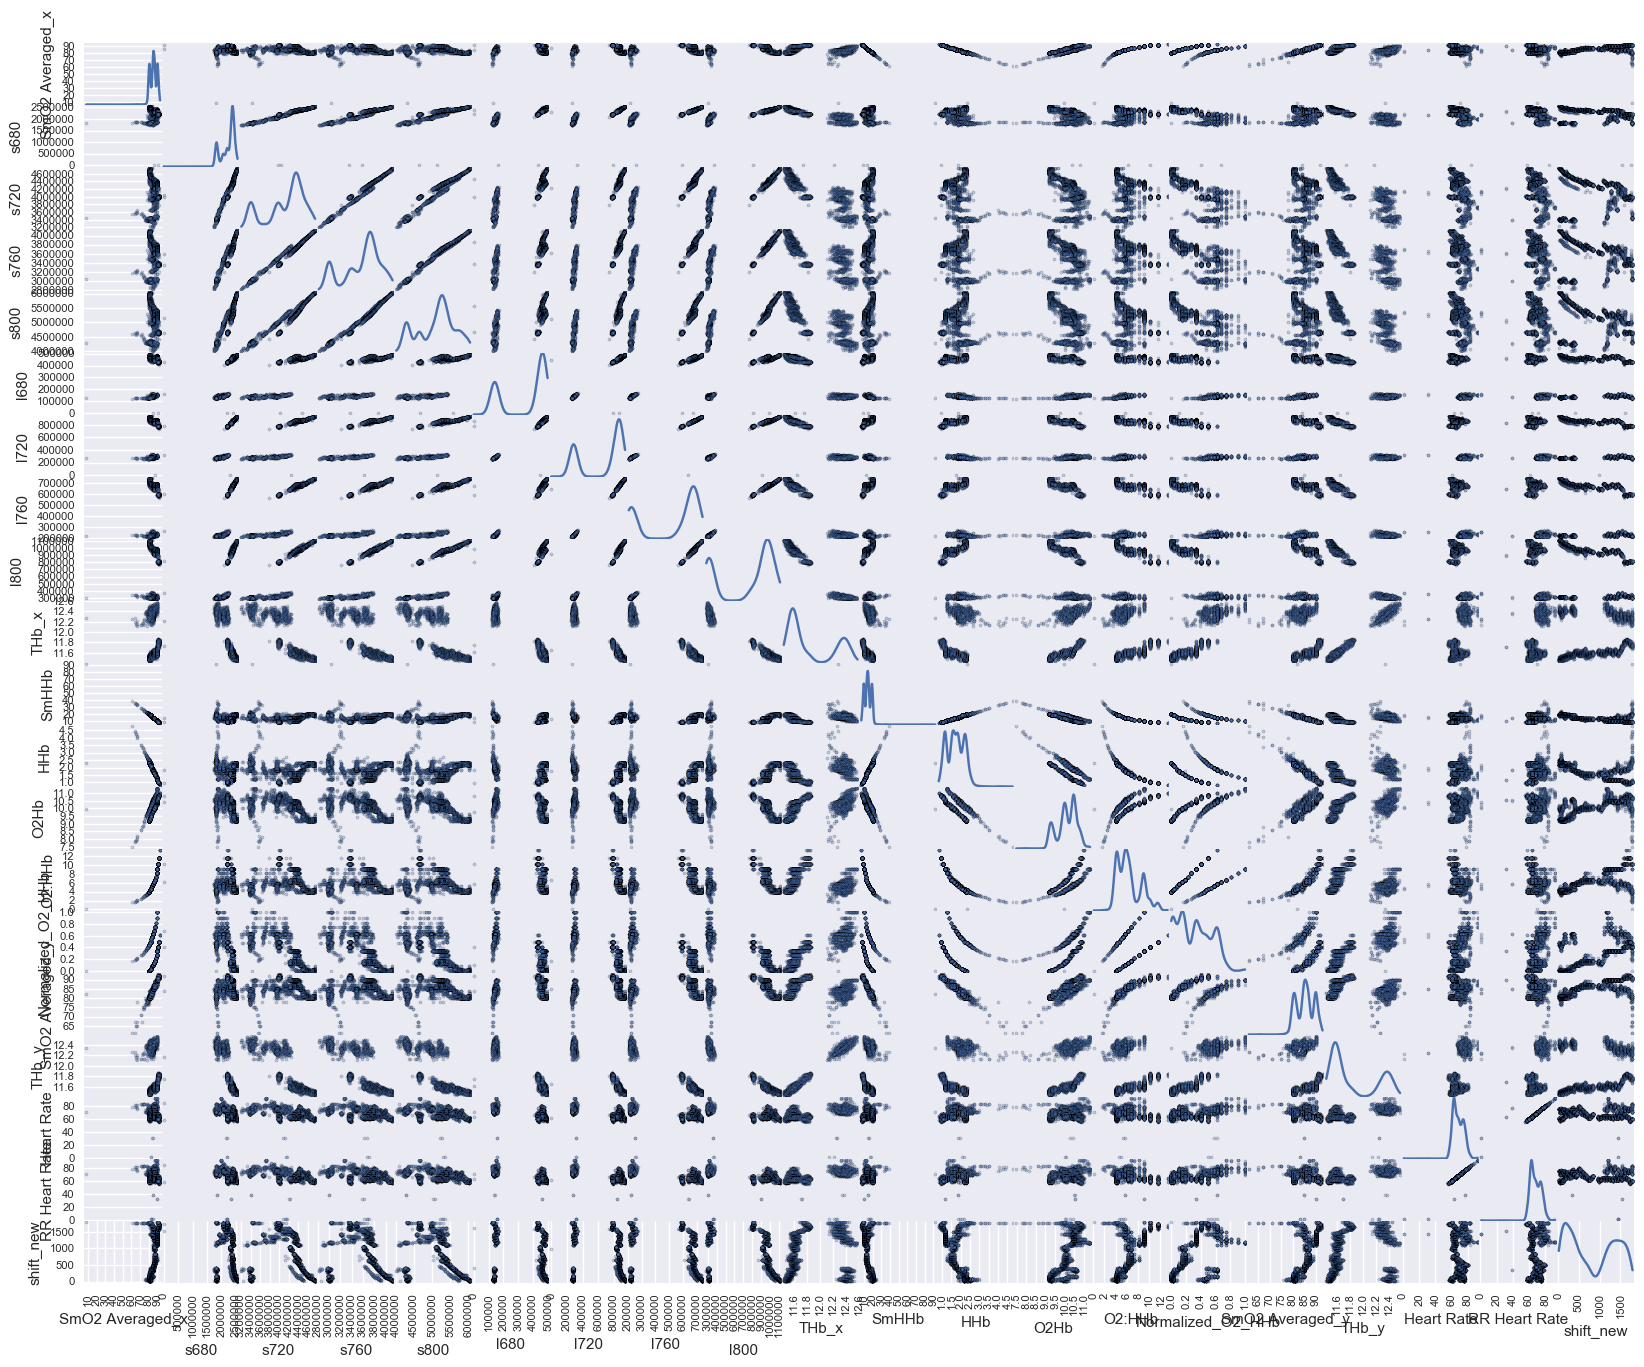

In [73]:
pd.scatter_matrix(vertical_stack, alpha = 0.3, figsize = (20,16), diagonal = 'kde');

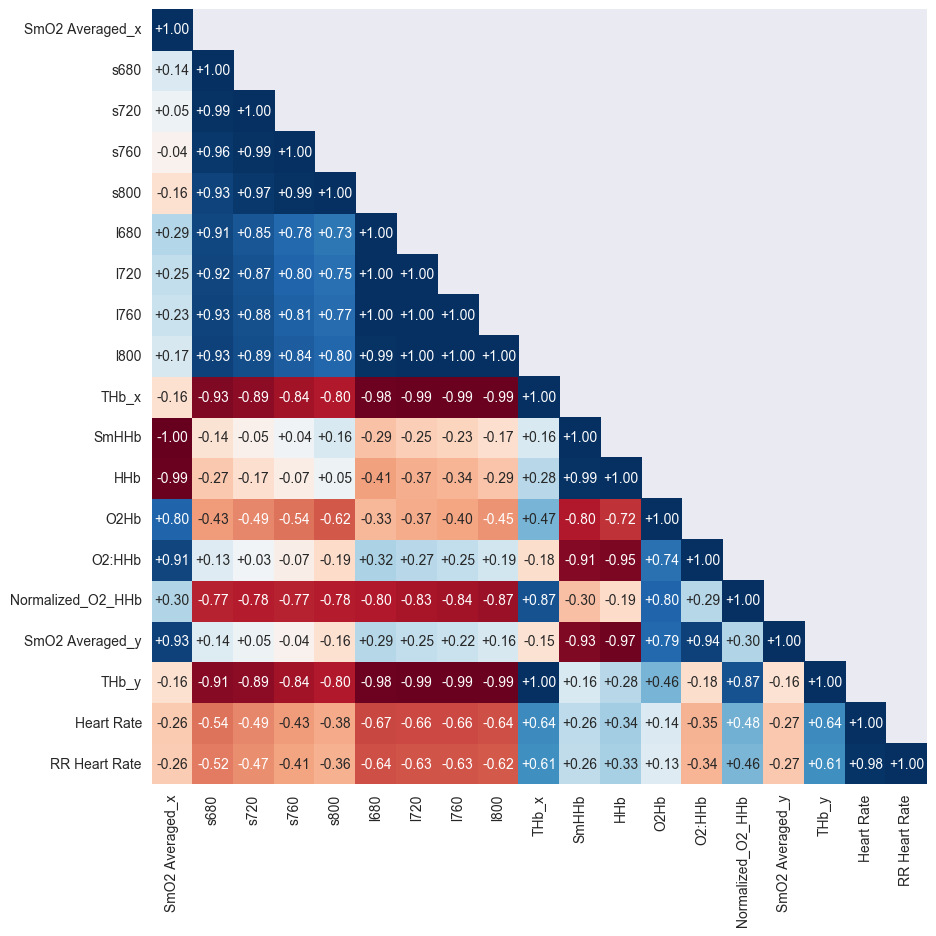

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# get the feature correlations
corr = vertical_stack.corr()

# create a mask so we only see the correlation values once
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches

# plot the heatmap
with sns.axes_style("white"):
    sns.heatmap(corr, mask=mask, annot=True, cmap='RdBu', fmt='+.2f', cbar=False)

In [40]:
# reindex 
vertical_stack = vertical_stack.reset_index()
# vertical_stack
vertical_stack.drop(['index'], axis = 1, inplace=True)
vertical_stack.dropna(how='any')


,SmO2 Averaged_x,s680,s720,s760,s800,l680,l720,l760,l800,THb_x,shift,SmHHb,HHb,O2Hb,O2:HHb,Normalized_O2_HHb,SmO2 Averaged_y,THb_y,Heart Rate,RR Heart Rate
0,80.0,1842372.0,3433461.0,3035776.0,4354345.0,136292.0,278251.0,222780.0,317085.0,12.38,00:00:16,20.0,2.4760,9.9040,4.000000,0.439024,80,12.43,75,75.018315
1,80.0,1835872.0,3420182.0,3020543.0,4330833.0,134810.0,276001.0,221433.0,313725.0,12.43,00:00:16.500000,20.0,2.4860,9.9440,4.000000,0.439024,80,12.39,75,75.018315
2,80.0,1839622.0,3428461.0,3030196.0,4349293.0,136665.0,278728.0,223080.0,316905.0,12.39,00:00:17,20.0,2.4780,9.9120,4.000000,0.439024,80,12.39,75,75.018315
3,80.0,1836259.0,3421972.0,3023095.0,4333888.0,135711.0,277520.0,222095.0,314815.0,12.42,00:00:17.500000,20.0,2.4840,9.9360,4.000000,0.439024,81,12.41,75,75.018315
4,81.0,1836027.0,3419434.0,3019762.0,4329108.0,136325.0,277840.0,221934.0,314208.0,12.41,00:00:18,19.0,2.3579,10.0521,4.263158,0.468549,81,12.41,75,75.018315
5,81.0,1836027.0,3419434.0,3019762.0,4329108.0,136325.0,277840.0,221934.0,314208.0,12.41,00:00:18.500000,19.0,2.3579,10.0521,4.263158,0.468549,82,12.50,75,75.018315
6,81.0,1836971.0,3420894.0,3022338.0,4332646.0,135937.0,278043.0,222689.0,315098.0,12.44,00:00:19,19.0,2.3636,10.0764,4.263158,0.468549,82,12.50,75,75.018315
7,82.0,1830167.0,3410449.0,3010144.0,4312325.0,134556.0,275786.0,221509.0,311171.0,12.50,00:00:19.500000,18.0,2.2500,10.2500,4.555556,0.501355,80,12.38,75,75.018315
8,81.0,1740933.0,3242003.0,2861273.0,4100410.0,129347.0,262913.0,209913.0,297290.0,12.39,00:00:20,19.0,2.3541,10.0359,4.263158,0.468549,80,12.38,75,75.018315
9,80.0,1826842.0,3402957.0,3001790.0,4297710.0,134758.0,274327.0,218360.0,309755.0,12.38,00:00:20.500000,20.0,2.4760,9.9040,4.000000,0.439024,81,12.41,75,75.018315


In [41]:
# convert to float32 or float64
for col in vertical_stack.columns:
#     if  vertical_stack.loc[lambda df: df.columns[column].dtypes == np.float64]
#     if vertical_stack.columns[column].dtype == float64:
    if vertical_stack[col].dtype == np.float64:
        # Change data type of DataFrame column
#         df.column_name = df.column_name.astype(np.int64)
        vertical_stack[col] = vertical_stack[col].astype(np.float32)
    elif vertical_stack[col].dtype == np.int64:
        vertical_stack[col] = vertical_stack[col].astype(np.int32)
    else:
        continue 

# new_list = vertical_stack.select_dtypes(include=['float64']).astype('float32')

# convert timedelta to an integer to use for ML
vertical_stack['shift_new'] = ((vertical_stack['shift']) / np.timedelta64(1, 's')).astype('float32')

print (vertical_stack.head())
vertical_stack.info()
vertical_stack = vertical_stack.fillna(method='ffill')
vertical_stack.isnull().any()
print (vertical_stack)

   SmO2 Averaged_x       s680       s720       s760       s800      l680  \
0             80.0  1842372.0  3433461.0  3035776.0  4354345.0  136292.0   
1             80.0  1835872.0  3420182.0  3020543.0  4330833.0  134810.0   
2             80.0  1839622.0  3428461.0  3030196.0  4349293.0  136665.0   
3             80.0  1836259.0  3421972.0  3023095.0  4333888.0  135711.0   
4             81.0  1836027.0  3419434.0  3019762.0  4329108.0  136325.0   

       l720      l760      l800  THb_x    ...      SmHHb     HHb     O2Hb  \
0  278251.0  222780.0  317085.0  12.38    ...       20.0  2.4760   9.9040   
1  276001.0  221433.0  313725.0  12.43    ...       20.0  2.4860   9.9440   
2  278728.0  223080.0  316905.0  12.39    ...       20.0  2.4780   9.9120   
3  277520.0  222095.0  314815.0  12.42    ...       20.0  2.4840   9.9360   
4  277840.0  221934.0  314208.0  12.41    ...       19.0  2.3579  10.0521   

     O2:HHb  Normalized_O2_HHb  SmO2 Averaged_y  THb_y  Heart Rate  \
0  4.00000

In [42]:
""" SELECT WHICH DATAFRAMEs TO USE HERE """

# Extract feature columns
features = list(vertical_stack.columns[0:])

# feature_cols_1 = list(merged_new_1.columns[:-2])
# feature_cols_2 = list(merged_new_2.columns[:-2])

feature_cols_both = list(vertical_stack.columns[[1,2,3,4,5,6,7,8,15, -1]])

# feature_cols_both = list(vertical_stack.concat([comb.ix[:,1:11],comb.ix[:,15]], axis=1))

# Extract target column 'Heart Rate' 
# target_col_hr_1 = merged_new_1.columns[-2]
# target_col_rrhr_1 = merged_new_1.columns[-1]

# target_col_hr_2 = merged_new_2.columns[-2]
# target_col_rrhr_2 = merged_new_2.columns[-1]

target_col_hr_both = vertical_stack.columns[-3:-2]
target_col_rrhr_both = list(vertical_stack.columns[-2:-1])


# Show the list of columns
print ("All columns: \n{}".format(list(vertical_stack.columns[0:])))
print ("\nFeature columns:\n{}".format(feature_cols_both))
print ("\nTarget column: {}".format(target_col_rrhr_both))
# print "\nTarget column: {}".format(target_col_2)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = vertical_stack[feature_cols_both]
# y_all_1 = merged_new_1[target_col_1]
# y_all_2 = merged_new_1[target_col_2]
y_all_hr = vertical_stack[target_col_hr_both]
y_all_rrhr = vertical_stack[target_col_rrhr_both]             
# y_all_rrhr.values.ravel()
# y_all_rrhr=y_all_rrhr.squeeze()

# Show the feature information by printing the first five rows
print ("\nFeature values:")
print (X_all.head())
print (type(X_all), X_all.shape)
print ("\nTarget values:")
print (y_all_rrhr.head)
# y_all = y_all_rrhr.reshape(y_all_rrhr,(y_all_rrhr.shape[0]),1) 
y_all_rrhr.values.ravel()
y = y_all_rrhr.values.ravel()
y_all_rrhr = np.array(y).astype('|S6')
print (type(y_all_rrhr), y_all_rrhr.shape)
# print vertical_stack['RR Heart Rate']
# print vertical_stack.loc[vertical_stack['RR Heart Rate'] == 0]
# print vertical_stack


All columns: 
['SmO2 Averaged_x', 's680', 's720', 's760', 's800', 'l680', 'l720', 'l760', 'l800', 'THb_x', 'shift', 'SmHHb', 'HHb', 'O2Hb', 'O2:HHb', 'Normalized_O2_HHb', 'SmO2 Averaged_y', 'THb_y', 'Heart Rate', 'RR Heart Rate', 'shift_new']

Feature columns:
['s680', 's720', 's760', 's800', 'l680', 'l720', 'l760', 'l800', 'Normalized_O2_HHb', 'shift_new']

Target column: ['RR Heart Rate']

Feature values:
        s680       s720       s760       s800      l680      l720      l760  \
0  1842372.0  3433461.0  3035776.0  4354345.0  136292.0  278251.0  222780.0   
1  1835872.0  3420182.0  3020543.0  4330833.0  134810.0  276001.0  221433.0   
2  1839622.0  3428461.0  3030196.0  4349293.0  136665.0  278728.0  223080.0   
3  1836259.0  3421972.0  3023095.0  4333888.0  135711.0  277520.0  222095.0   
4  1836027.0  3419434.0  3019762.0  4329108.0  136325.0  277840.0  221934.0   

       l800  Normalized_O2_HHb  shift_new  
0  317085.0           0.439024       16.0  
1  313725.0           0.43

In [43]:
# Import any additional functionality you may need here
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split, ShuffleSplit
import datetime

# Shuffle and split the dataset into the number of training and testing points above
def shuffle_split_data(X, y):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, stratify=y, test_size=0.25, random_state=0) 
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = shuffle_split_data(X_all, y_all_rrhr)

# Success
print ("Training and testing split was successful.")

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

vertical_stack.info()
X_train.info()
X_test.info()
# y_train.info()
# y_test.info()

Training and testing split was successful.
Training set has 2506 samples.
Testing set has 836 samples.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3342 entries, 0 to 3341
Data columns (total 21 columns):
SmO2 Averaged_x      3342 non-null float32
s680                 3342 non-null float32
s720                 3342 non-null float32
s760                 3342 non-null float32
s800                 3342 non-null float32
l680                 3342 non-null float32
l720                 3342 non-null float32
l760                 3342 non-null float32
l800                 3342 non-null float32
THb_x                3342 non-null float32
shift                3342 non-null timedelta64[ns]
SmHHb                3342 non-null float32
HHb                  3342 non-null float32
O2Hb                 3342 non-null float32
O2:HHb               3342 non-null float32
Normalized_O2_HHb    3342 non-null float32
SmO2 Averaged_y      3342 non-null int32
THb_y                3342 non-null float32
Heart Rate

In [44]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop t"he clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print ("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print ("Made predictions in {:.4f} seconds.".format(end - start))
    return f1_score(target, y_pred, average='weighted')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print ("F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train)))
    print ("F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test)))

In [74]:
# Import supervised learning models from sklearn
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression

# Initialize the models
clf_A = svm.SVC(random_state=0)
# clf_B = LinearRegression(fit_intercept=False, normalize=True, copy_X=False, n_jobs=1)
clf_C = GaussianNB()

# Set up the training set sizes
# loop thru models, then thru train sizes
for clf in [clf_A, clf_C]:
    print ("\n{}: \n".format(clf.__class__.__name__))
    for n in [1000, 2000, 3000]:
        train_predict(clf, X_train[:n], y_train[:n], X_test, y_test)
        print ("------------------------------------------")
        print ("\n")



SVC: 

Training a SVC using a training set size of 1000. . .
Trained model in 0.2385 seconds
Made predictions in 0.0995 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0780 seconds.
F1 score for test set: 0.0398.
------------------------------------------


Training a SVC using a training set size of 2000. . .


C:\Users\LeviZ\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Trained model in 0.9251 seconds
Made predictions in 0.4371 seconds.
F1 score for training set: 0.9978.
Made predictions in 0.2030 seconds.
F1 score for test set: 0.0600.
------------------------------------------


Training a SVC using a training set size of 2506. . .
Trained model in 1.4050 seconds
Made predictions in 0.6385 seconds.
F1 score for training set: 0.9956.
Made predictions in 0.2081 seconds.
F1 score for test set: 0.0782.
------------------------------------------



GaussianNB: 

Training a GaussianNB using a training set size of 1000. . .
Trained model in 0.0045 seconds
Made predictions in 0.0050 seconds.
F1 score for training set: 0.0662.
Made predictions in 0.0050 seconds.
F1 score for test set: 0.0541.
------------------------------------------


Training a GaussianNB using a training set size of 2000. . .
Trained model in 0.0085 seconds
Made predictions in 0.0090 seconds.
F1 score for training set: 0.0589.
Made predictions in 0.0050 seconds.
F1 score for test set: 0.

C:\Users\LeviZ\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


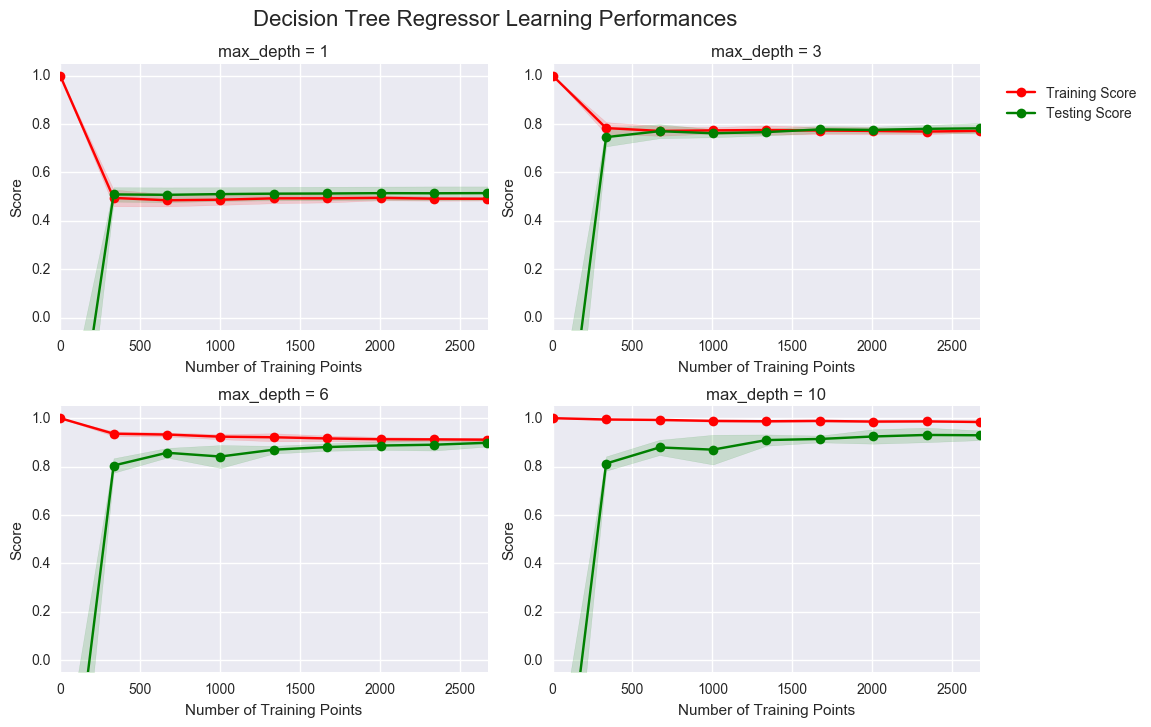

In [46]:
from sklearn import preprocessing

#convert y_train to fix error
y_all_new=preprocessing.LabelEncoder().fit_transform(y_all_rrhr)

# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(X_all, y_all_new)

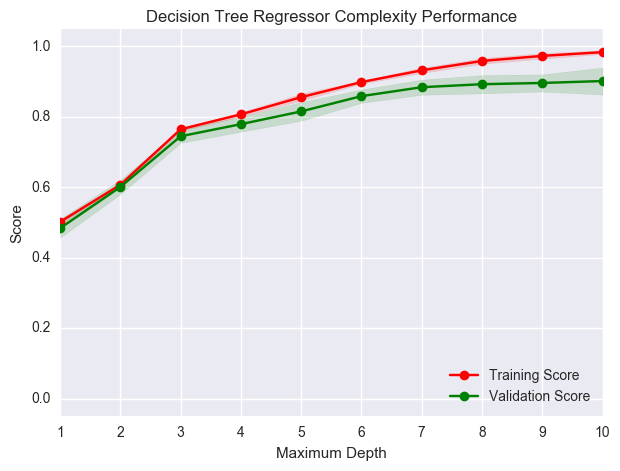

In [47]:
#convert y_train to fix error - change dtype to work
Y_train=preprocessing.LabelEncoder().fit_transform(y_train)

# Produce complexity curve - shaded region denotes uncertainty
vs.ModelComplexity(X_train, Y_train)

In [48]:
# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn import model_selection
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor 
# Import 'r2_score'
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)

    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor(random_state=0)

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth': range(1, 25)}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)
    
    # Create the grid search object
    grid = GridSearchCV(regressor, params, scoring_fnc, fit_params=None, n_jobs=1, iid=True, refit=True, cv=cv_sets, verbose=0, pre_dispatch='2*n_jobs', error_score='raise')

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [49]:
# X_train_new = str(X_train)
# y_train_new = str(y_train)
#convert y_train to fix error
from sklearn import preprocessing
Y_train=preprocessing.LabelEncoder().fit_transform(y_train)

# Fit the training data to the model using grid search
reg = fit_model(X_train, Y_train)

# Produce the value for 'max_depth' for optiman model
print ("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))

Parameter 'max_depth' is 11 for the optimal model.


In [50]:
"""Decision Tree Regressor
"""
Y_test=preprocessing.LabelEncoder().fit_transform(y_test)

# Create a decision tree regressor and fit it to the training set
from sklearn import tree
regressor = tree.DecisionTreeRegressor(random_state=0)
regressor = regressor.fit(X_train,Y_train)

# Report the score of the prediction using the testing set
score = regressor.score(X_test, Y_test)
print (score)

0.28724082064


In [78]:
vertical_stack_new = vertical_stack[[1,2,3,4,5,6,7,8,15,-2,-1]].astype(np.float32)
vertical_stack_flow = vertical_stack[[1,2,3,4,5,6,7,8,15,-3]].astype(np.float32)

vertical_stack_new = vertical_stack_new.fillna(method='ffill')
vertical_stack_new.isnull().any()
# # vertical_stack_new.values.ravel()
# y = vertical_stack_new.values.ravel()
# vertical_stack_new = np.array(y).astype(np.float64)
# print (vertical_stack_new)

print (np.isinf(vertical_stack_new).any())

print (np.isnan(vertical_stack_new).any())
print (vertical_stack_new.head(n=1))

s680                 False
s720                 False
s760                 False
s800                 False
l680                 False
l720                 False
l760                 False
l800                 False
Normalized_O2_HHb    False
RR Heart Rate        False
shift_new            False
dtype: bool
s680                 False
s720                 False
s760                 False
s800                 False
l680                 False
l720                 False
l760                 False
l800                 False
Normalized_O2_HHb    False
RR Heart Rate        False
shift_new            False
dtype: bool
        s680       s720       s760       s800      l680      l720      l760  \
0  1842372.0  3433461.0  3035776.0  4354345.0  136292.0  278251.0  222780.0   

       l800  Normalized_O2_HHb  RR Heart Rate  shift_new  
0  317085.0           0.439024      75.018318       16.0  


In [77]:
# Log Transform data
# Scale the data using the natural logarithm
# print vertical_stack_new.iloc[:, :8]
data_features = vertical_stack_new.iloc[:, :8]
data_predict = vertical_stack_new.iloc[:, 9:10]
# print (data_predict)
log_data = np.log(data_features)
# print (log_data)


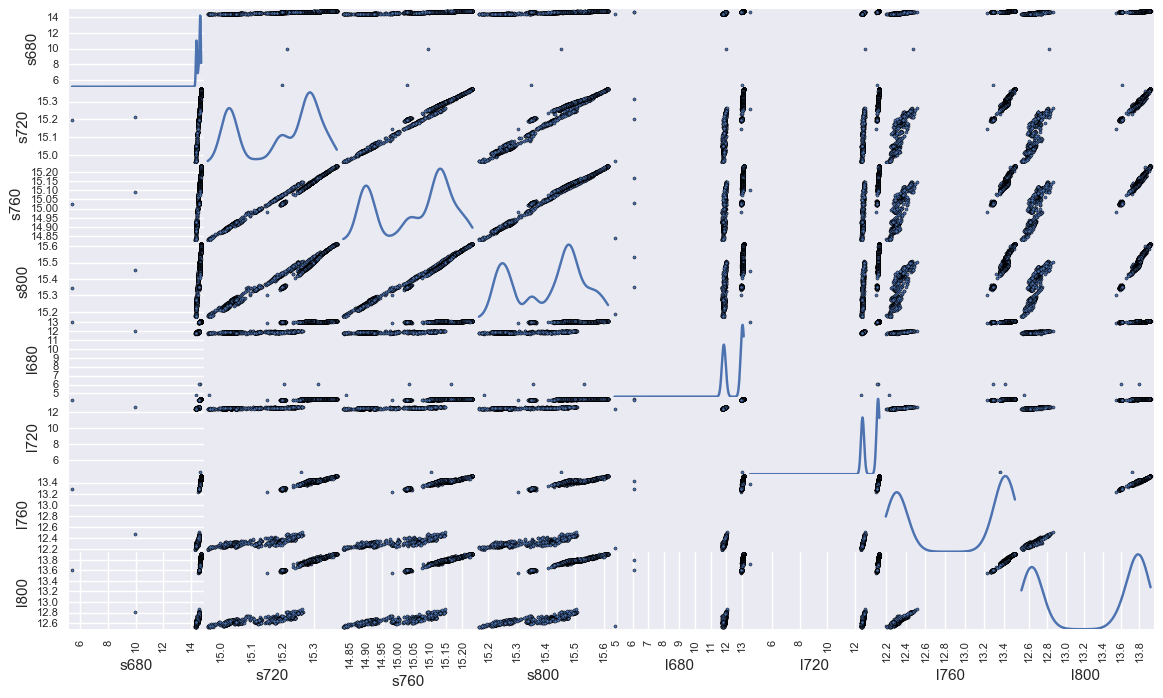

In [386]:
from pandas.tools.plotting import scatter_matrix

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(good_data, alpha = 1, figsize = (14,8), diagonal = 'kde');

In [53]:
# Remove outliers

# For each feature find the data points with extreme high or low values
from collections import defaultdict
outliers = defaultdict(lambda: 0)
for feature in log_data.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = ((Q3 - Q1)*1.5)
    
    # Display the outliers
    print ("Data points considered outliers for the feature '{}':".format(feature))
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    
    outliers_df = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    for index in outliers_df.index.values:
        outliers[index] += 1
#     display(outliers_df)
# OPTIONAL: Select the indices for data points you wish to remove
outliers_list = [index for (index, count) in outliers.items() if count > 1]
print ("Index of outliers for more than one feature: {} ".format(sorted(outliers_list)))

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers_list]).reset_index(drop = True)
# print outliers_list

Data points considered outliers for the feature 's680':


,s680,s720,s760,s800,l680,l720,l760,l800
855,9.983685,15.213266,15.092581,15.452608,12.004213,12.692909,12.474048,12.817462
3309,5.389072,15.197294,15.026589,15.348234,12.976924,13.569009,13.292801,13.605862


Data points considered outliers for the feature 's720':


,s680,s720,s760,s800,l680,l720,l760,l800
8,14.369932,14.991702,14.866777,15.226598,11.770254,12.479578,12.254449,12.602464
279,14.362008,14.981762,14.855123,15.205192,11.768567,12.464333,12.240436,12.564411
303,14.360738,14.980458,14.852794,15.201821,11.773828,12.469625,12.237377,12.556275
372,14.369347,14.988407,14.862935,15.214696,11.790163,12.491958,12.261825,12.586678
384,14.372725,14.992100,14.867995,15.221435,11.799404,12.493163,12.270333,12.596255
387,14.378291,14.997016,14.875089,15.230149,11.821608,12.503696,12.280099,12.612457
406,14.374815,14.994043,14.871385,15.225853,11.814851,12.503514,12.283950,12.614836
415,14.361124,14.981168,14.854608,15.204583,11.779228,12.479487,12.250310,12.576480
452,14.362898,14.983757,14.859580,15.213944,11.765954,12.466916,12.246038,12.587856
462,14.382416,14.998017,14.871929,15.214681,11.872005,12.546359,12.312947,12.627005


Data points considered outliers for the feature 's760':


,s680,s720,s760,s800,l680,l720,l760,l800
279,14.362008,14.981762,14.855123,15.205192,11.768567,12.464333,12.240436,12.564411
303,14.360738,14.980458,14.852794,15.201821,11.773828,12.469625,12.237377,12.556275
415,14.361124,14.981168,14.854608,15.204583,11.779228,12.479487,12.250310,12.576480


Data points considered outliers for the feature 's800':


,s680,s720,s760,s800,l680,l720,l760,l800


Data points considered outliers for the feature 'l680':


,s680,s720,s760,s800,l680,l720,l760,l800
1769,14.692740,15.311902,15.165627,15.532837,6.115892,13.667448,13.418995,13.799059
3155,14.607045,15.203003,15.032716,15.353674,6.061457,13.571340,13.290432,13.602522


Data points considered outliers for the feature 'l720':


,s680,s720,s760,s800,l680,l720,l760,l800
2453,14.652537,15.25906,15.102726,15.450649,13.006699,4.406719,13.367657,13.721431


Data points considered outliers for the feature 'l760':


,s680,s720,s760,s800,l680,l720,l760,l800


Data points considered outliers for the feature 'l800':


,s680,s720,s760,s800,l680,l720,l760,l800


Index of outliers for more than one feature: [279, 303, 415] 


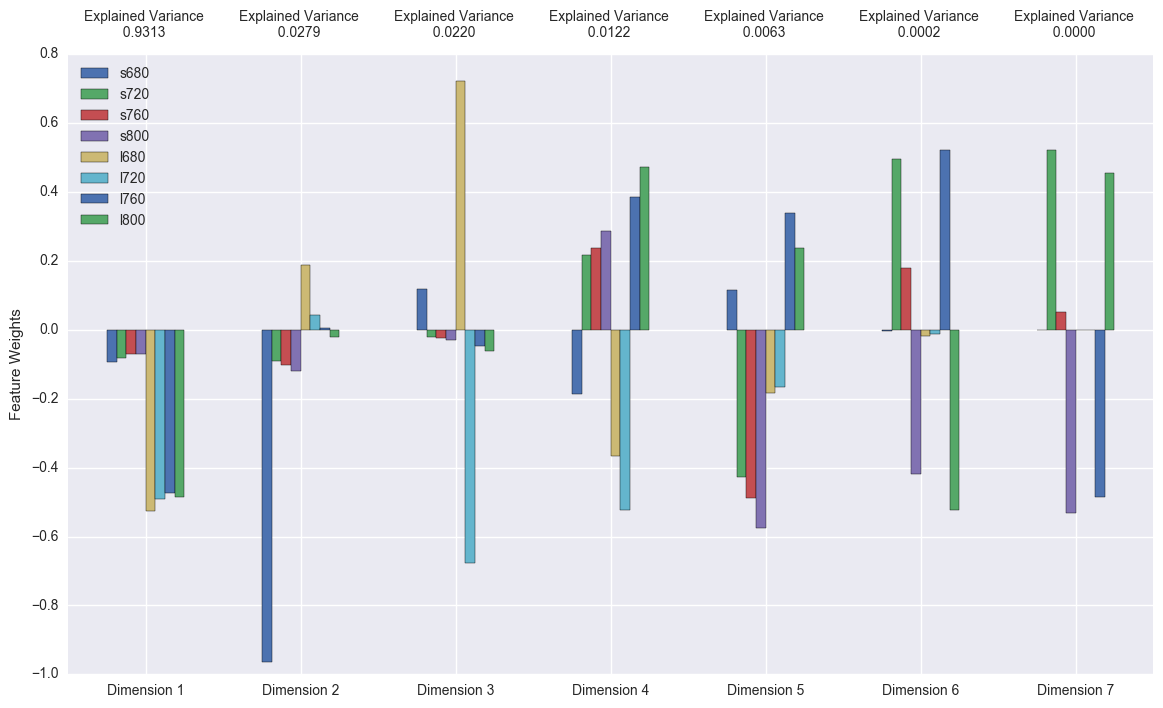

In [54]:
# Apply PCA by fitting the good data with the same number of dimensions as features
from sklearn.decomposition import PCA
import renders as rs

pca = PCA(n_components=7)
pca.fit(good_data)
# PCA(copy=True, n_components=2, whiten=False)
# print(pca.explained_variance_ratio_) 

# Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_data)
# print pca_samples
# Generate PCA results plot
pca_results = rs.pca_results(good_data, pca)

In [55]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7
0,1.5820,0.0516,-0.0081,-0.0247,0.0736,-0.0281,0.0014
1,1.6011,0.0543,-0.0096,-0.0267,0.0791,-0.0260,0.0001
2,1.5798,0.0541,-0.0074,-0.0271,0.0751,-0.0278,0.0002
3,1.5917,0.0553,-0.0089,-0.0288,0.0778,-0.0263,0.0001
4,1.5902,0.0567,-0.0062,-0.0329,0.0776,-0.0259,-0.0002
5,1.5902,0.0567,-0.0062,-0.0329,0.0776,-0.0259,-0.0002
6,1.5882,0.0554,-0.0091,-0.0292,0.0788,-0.0255,-0.0008
7,1.6074,0.0582,-0.0100,-0.0314,0.0828,-0.0217,-0.0032
8,1.7150,0.1133,-0.0030,-0.0625,0.1384,-0.0376,-0.0003
9,1.6189,0.0609,-0.0044,-0.0387,0.0815,-0.0269,0.0022


# Implementation: Dimensionality Reduction

In [56]:
# Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2)
pca.fit(good_data)

# Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_data)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

In [57]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,1.5820,0.0516
1,1.6011,0.0543
2,1.5798,0.0541
3,1.5917,0.0553
4,1.5902,0.0567
5,1.5902,0.0567
6,1.5882,0.0554
7,1.6074,0.0582
8,1.7150,0.1133
9,1.6189,0.0609


# Clustering

In [58]:
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import KMeans

for i in range(2,8):
    # Apply your clustering algorithm of choice to the reduced data 
    n_comp = i
    clusterer = GMM(n_components=n_comp)
    clusterer.fit(reduced_data)

    # Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # Find the cluster centers
    centers = clusterer.means_

    # Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds)
    print ("Silhoette Score for " + str(n_comp) + " components equals: " + str(score))

n_comp=2
clusterer = GMM(n_components=n_comp)
clusterer.fit(reduced_data)

# Predict the cluster for each data point
preds = clusterer.predict(reduced_data)

# Find the cluster centers
centers = clusterer.means_

# Predict the cluster for each transformed sample data point
sample_preds = clusterer.predict(pca_samples)

# Calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(reduced_data, preds)

Silhoette Score for 2 components equals: 0.931338135775
Silhoette Score for 3 components equals: 0.932660971146
Silhoette Score for 4 components equals: 0.767001770597
Silhoette Score for 5 components equals: 0.828179550196
Silhoette Score for 6 components equals: 0.667906408694
Silhoette Score for 7 components equals: 0.476378062101


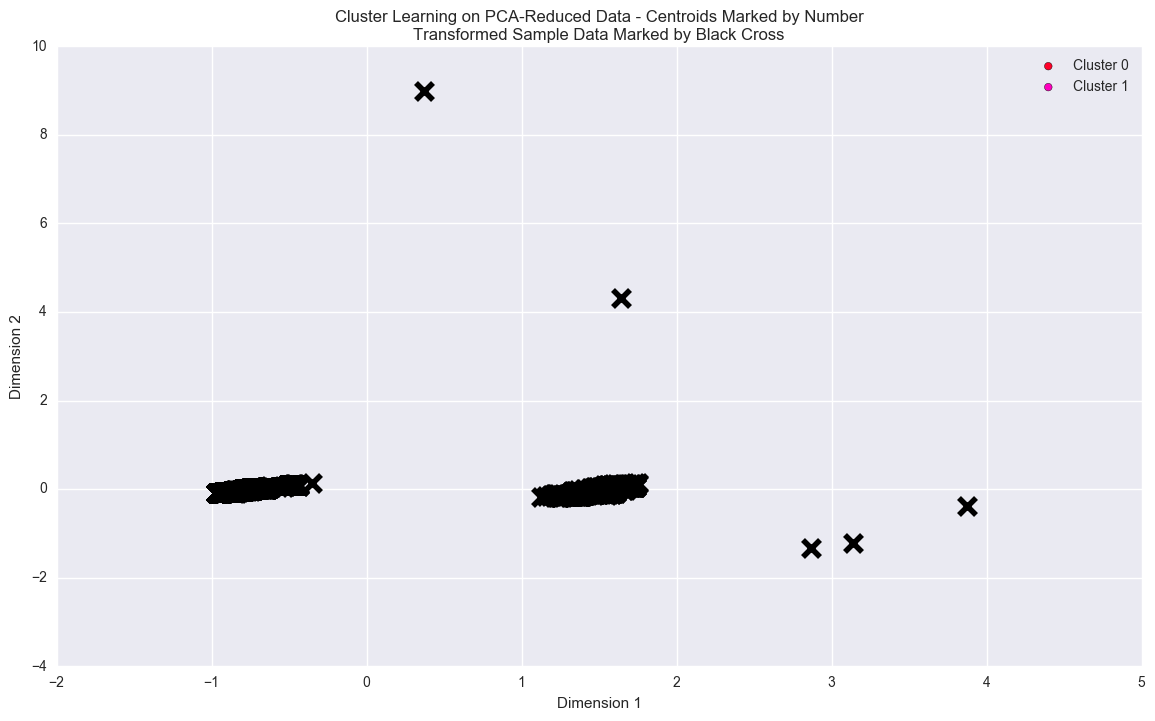

In [59]:
# Display the results of the clustering from implementation
rs.cluster_results(reduced_data, preds, centers, pca_samples)

In [60]:
# Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data_features.keys())
true_centers.index = segments
print ("True Centers:")
display(true_centers)
print ("True Centers minus the mean:")
display(true_centers - data_features.mean().round())
print ("True Centers minus the median:")
display(true_centers - data_features.median().round())

True Centers:


,s680,s720,s760,s800,l680,l720,l760,l800
Segment 0,2358796.0,4375220.0,3761227.0,5369727.0,461069.0,860164.0,666347.0,958126.0
Segment 1,1948866.0,3644773.0,3213196.0,4575766.0,139411.0,282246.0,227760.0,318086.0


True Centers minus the mean:


,s680,s720,s760,s800,l680,l720,l760,l800
Segment 0,122388.0,232696.0,172973.0,247115.0,104209.0,187181.0,141111.0,205235.0
Segment 1,-287542.0,-497751.0,-375058.0,-546846.0,-217449.0,-390737.0,-297476.0,-434805.0


True Centers minus the median:


,s680,s720,s760,s800,l680,l720,l760,l800
Segment 0,11410.0,82586.0,75331.0,139083.0,6018.0,11658.0,8091.0,22616.0
Segment 1,-398520.0,-647861.0,-472700.0,-654878.0,-315640.0,-566260.0,-430496.0,-617424.0


In [62]:
print (vertical_stack_new.head(n=1))
print (vertical_stack_new.loc[vertical_stack_new['shift_new'] < 16.0])


        s680       s720       s760       s800      l680      l720      l760  \
0  1842372.0  3433461.0  3035776.0  4354345.0  136292.0  278251.0  222780.0   

       l800  Normalized_O2_HHb  RR Heart Rate  shift_new  
0  317085.0           0.439024      75.018318       16.0  
           s680       s720       s760       s800      l680      l720  \
1086  2429896.0  4508569.0  3908478.0  5720432.0  470717.0  894550.0   
1087  2555574.0  4740368.0  4109880.0  6021743.0  495871.0  940702.0   

          l760       l800  Normalized_O2_HHb  RR Heart Rate  shift_new  
1086  703861.0  1051111.0           0.017544      59.020172       15.0  
1087  740383.0  1106141.0           0.058824      59.020172       15.5  


# Reccurrent Neural Network

In [66]:
vertical_stack_flow = vertical_stack[[1,2,3,4,5,6,7,8,15,-3]].astype(np.float32)
print (vertical_stack_flow.head(n=1))
vertical_stack_flow=vertical_stack_flow.rename(columns = {'Heart Rate':'Heart_Rate'})
vertical_stack_flow=vertical_stack_flow.rename(columns = {'Normalized_O2:HHb':'Normalized_O2_HHb'})
print (vertical_stack_flow.head(n=1))

tensorflow_set_1 = vertical_stack_flow.ix[0:1769, :]
# print(tensorflow_set_1)
tensorflow_set_2 = vertical_stack_flow.ix[1770:3300, :]
# print(tensorflow_set_2)
tensorflow_set_3 = vertical_stack_flow.ix[3301:, :]
tensorflow_set_all = vertical_stack_flow.ix[:, :]

tensorflow_set_1.to_csv('tensorflow_csv_1.csv', index=False)
tensorflow_set_2.to_csv('tensorflow_csv_2.csv', index=False)
tensorflow_set_3.to_csv('tensorflow_csv_3.csv', index=False)
tensorflow_set_all.to_csv('tensorflow_csv_all.csv', index=False)


# dataframe_set = tf.contrib.learn.datasets.base.load_csv_with_header(
#     filename=IRIS_TRAINING,
#     target_dtype=np.int,
#     features_dtype=np.float32)

        s680       s720       s760       s800      l680      l720      l760  \
0  1842372.0  3433461.0  3035776.0  4354345.0  136292.0  278251.0  222780.0   

       l800  Normalized_O2_HHb  Heart Rate  
0  317085.0           0.439024        75.0  
        s680       s720       s760       s800      l680      l720      l760  \
0  1842372.0  3433461.0  3035776.0  4354345.0  136292.0  278251.0  222780.0   

       l800  Normalized_O2_HHb  Heart_Rate  
0  317085.0           0.439024        75.0  


In [67]:
with open("tensorflow_csv_1.csv",'r') as f:
    with open("updated_tensorflow_csv_1.csv",'w') as f1:
        next(f) # skip header line
        for line in f:
            f1.write(line)
with open("tensorflow_csv_2.csv",'r') as f:
    with open("updated_tensorflow_csv_2.csv",'w') as f1:
        next(f) # skip header line
        for line in f:
            f1.write(line)
with open("tensorflow_csv_3.csv",'r') as f:
    with open("updated_tensorflow_csv_3.csv",'w') as f1:
        next(f) # skip header line
        for line in f:
            f1.write(line)     
with open("tensorflow_csv_all.csv",'r') as f:
    with open("updated_tensorflow_csv_all.csv",'w') as f1:
        next(f) # skip header line
        for line in f:
            f1.write(line)   

In [75]:
import tensorflow as tf
import pandas as pd 
import functools
import numpy as np
import csv
tf.Graph().as_default()
tf.reset_default_graph()

COLUMNS = ["s680", "s720", "s760", "s800", "l680", "l720",
           "l760", "l800", "Normalized_O2_HHb", "Heart_Rate"]
FEATURES = ["s680", "s720", "s760", "s800", "l680", "l720",
           "l760", "l800", "Normalized_O2_HHb"]
feature_cols = [tf.contrib.layers.real_valued_column(k)
                  for k in FEATURES]

# tensorflow_dataframe= np.genfromtxt('updated_tensorflow_csv_2.csv',delimiter=',')
tensorflow_train_dataframe = pd.read_csv("updated_tensorflow_csv_1.csv", header=None)
tensorflow_test_dataframe = pd.read_csv("updated_tensorflow_csv_2.csv", header=None)
tensorflow_all_dataframe = pd.read_csv("updated_tensorflow_csv_all.csv", header=None)


train_input_data = [[[cell] for cell in row] for _, row in 
                    tensorflow_train_dataframe[tensorflow_train_dataframe.columns[0:9]].iterrows()]
train_input_data = list(np.array(train_input_data))
train_output_data = [[cell] for cell in tensorflow_train_dataframe[9].values.tolist()]

test_input_data = [[[cell] for cell in row] for _, row in 
                    tensorflow_test_dataframe[tensorflow_test_dataframe.columns[0:9]].iterrows()]
test_input_data = list(np.array(test_input_data))
test_output_data = [[cell] for cell in tensorflow_test_dataframe[9].values.tolist()]

# print ("input_data")
# print (train_input_data, test_input_data)
# print ("output_data")
# print (train_output_data, test_output_data)
# print ("input_data shape - train, test")
# print (train_input_data.shape, test_input_data.shape)

In [76]:
# https://udemy.com/deep-learning-recurrent-neural-networks-in-python
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.Graph().as_default()
tf.reset_default_graph()

# from tensorflow.python.ops import rnn as rnn_module
from tensorflow.python.ops.rnn import rnn as get_rnn_output
from tensorflow.python.ops.rnn_cell import BasicRNNCell, GRUCell, BasicLSTMCell
from sklearn.utils import shuffle

from util import init_weight


def x2sequence(x, T, D, batch_sz):
    print ("X2seq")
    print(x)
    # Permuting batch_size and n_steps
    x = tf.transpose(x, (1, 0, 2))
    print ("X2seq")
    print(x)
    # Reshaping to (n_steps*batch_size, n_input)
    x = tf.reshape(x, (T*batch_sz, D))
    print ("X2seq")
    print(x)
    # Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.split(0, T, x)
    print ("type(x):")
    print (type(x))
    print ("X2seq")
    print(x)
    return x

class SimpleRNN:
    def __init__(self, M):
        self.M = M # hidden layer size


    def fit(self, X, Y, batch_sz=7, learning_rate=10e-1, mu=.01, activation=tf.nn.sigmoid, epochs=100, show_fig=False):
        N, D, T = X.shape # X is of size N x T(n) x D
        print ("N, T, D = X.shape:")
        print (X.shape)
        K = 230
#         K = len(set(Y.flatten()))
        print ("len Y flatten")
        print (len(Y.flatten()))
        print ('K')
        print (K)
        M = self.M
        self.f = activation

        # initial weights
        # note: Wx, Wh, bh are all part of the RNN unit and will be created
        #       by BasicRNNCell
        Wo = init_weight(M, K).astype(np.float32)
        bo = np.zeros(K, dtype=np.float32)

        # make them tf variables
        self.Wo = tf.Variable(Wo)
        self.bo = tf.Variable(bo)
        
        print ("Wo shape")
        print (Wo.shape)        
        print ("bo shape")
        print (bo.shape)
        
        print ("self.Wo shape")
        print (self.Wo.get_shape())        
        print ("self.bo shape")
        print (self.bo.get_shape())
        
        # tf Graph input
        num_classes = Y.shape[1]
        tfX = tf.placeholder(tf.float32, shape=(batch_sz, D, T), name='inputs')
        tfY = tf.placeholder(tf.int64, shape=(batch_sz, num_classes), name='targets')

        # turn tfX into a sequence, e.g. T tensors all of size (batch_sz, D)
        sequenceX = x2sequence(tfX, T, D, batch_sz)

        # create the simple rnn unit
        rnn_unit = BasicRNNCell(num_units=self.M, activation=self.f)

        # Get rnn cell output
        # outputs, states = rnn_module.rnn(rnn_unit, sequenceX, dtype=tf.float32)
        outputs, states = get_rnn_output(rnn_unit, sequenceX, dtype=tf.float32)
        print ("outputs shape")
        print (outputs)
        # outputs are now of size (T, batch_sz, M)
        # so make it (batch_sz, T, M)
        outputs = tf.transpose(outputs, (1, 0, 2))
        outputs = tf.reshape(outputs, (T*batch_sz, M))
        print ("outputs shape")
        print (outputs.get_shape())

        # Linear activation, using rnn inner loop last output
#         logits = tf.matmul(outputs, self.Wo) + self.bo
#         print ("logits shape")
#         print (logits.get_shape())
#         predict_op = tf.argmax(logits, 1)
        print ("tfY")
        print (tfY.get_shape())
        targets = tf.reshape(tfY, (num_classes*batch_sz,))
        print ("targets reshaped")
        print (targets.get_shape())
        logits = tf.matmul(outputs, self.Wo) + self.bo
        print ("logits shape")
        print (logits.get_shape())
        predict_op = tf.argmax(logits, 1)
        
        cost_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, targets))
        train_op = tf.train.MomentumOptimizer(learning_rate, momentum=mu).minimize(cost_op)

        costs = []
        n_batches = int(N / batch_sz)

        init = tf.global_variables_initializer()
        with tf.Session() as session:
            session.run(init)
            for i in range(epochs):
                X, Y = shuffle(X, Y)
                n_correct = 0
                cost = 0
                for j in range(n_batches):
                    Xbatch = X[j*batch_sz:(j+1)*batch_sz]
                    Ybatch = Y[j*batch_sz:(j+1)*batch_sz]
          
                    _, c, p = session.run([train_op, cost_op, predict_op], feed_dict={tfX: Xbatch, tfY: Ybatch})
                    cost += c
                    for b in range(batch_sz):
                        idx = (b + 1)*T - 1
#                         n_correct += (p[idx] == Ybatch[b][-1])
                        n_correct += (((p[idx])-10) <= Ybatch[b][-1] <= ((p[idx])+10))

#                         n_correct += tf.logical_or((tf.greater(tf.argmax(Ybatch[b][-1], 1), (tf.argmax(p[idx], 1)-1))), \
#                             (tf.less(tf.argmax(Ybatch[b][-1], 1), (tf.argmax(p[idx], 1)+1))))
                if i % 10 == 0:
                    print ("i:", i, "cost:", cost, "classification rate:", (float(n_correct)/N))
                    print (p[idx],  Ybatch[b][-1])
                if n_correct == N:
                    print ("i:", i, "cost:", cost, "classification rate:", (float(n_correct)/N))
                    break
                costs.append(cost)

        if show_fig:
            plt.plot(costs)
            plt.show()

def parity(B=150, learning_rate=60e-3, epochs=1000):
#     X, Y = all_parity_pairs_with_sequence_labels(B)
#     X = train_input_data
#     Y = train_output_data
    X = np.array([[[cell] for cell in row] for _, row 
                  in tensorflow_all_dataframe[tensorflow_all_dataframe.columns[0:9]].iterrows()])
    Y = np.array([[cell] for cell in tensorflow_all_dataframe[9].values.tolist()])
    print("X shape, examples")
    print (X.shape, X[:2])
    print ("Y shape, examples")
    print (Y.shape, Y[:2])
    rnn = SimpleRNN(60)
    
    rnn.fit(X, Y,
        batch_sz=2,
        learning_rate=learning_rate,
        epochs=epochs,
        activation=tf.nn.sigmoid,
        show_fig=False
    )


if __name__ == '__main__':
    parity()


X shape, examples
(3342, 9, 1) [[[  1.84237200e+06]
  [  3.43346100e+06]
  [  3.03577600e+06]
  [  4.35434500e+06]
  [  1.36292000e+05]
  [  2.78251000e+05]
  [  2.22780000e+05]
  [  3.17085000e+05]
  [  4.39024389e-01]]

 [[  1.83587200e+06]
  [  3.42018200e+06]
  [  3.02054300e+06]
  [  4.33083300e+06]
  [  1.34810000e+05]
  [  2.76001000e+05]
  [  2.21433000e+05]
  [  3.13725000e+05]
  [  4.39024389e-01]]]
Y shape, examples
(3342, 1) [[ 75.]
 [ 75.]]
N, T, D = X.shape:
(3342, 9, 1)
len Y flatten
3342
K
230
Wo shape
(60, 230)
bo shape
(230,)
self.Wo shape
(60, 230)
self.bo shape
(230,)
X2seq
Tensor("inputs:0", shape=(2, 9, 1), dtype=float32)
X2seq
Tensor("transpose:0", shape=(9, 2, 1), dtype=float32)
X2seq
Tensor("Reshape:0", shape=(2, 9), dtype=float32)
type(x):
<class 'list'>
X2seq
[<tf.Tensor 'split:0' shape=(2, 9) dtype=float32>]
outputs shape
[<tf.Tensor 'RNN/BasicRNNCell/Sigmoid:0' shape=(2, 60) dtype=float32>]
outputs shape
(2, 60)
tfY
(2, 1)
targets reshaped
(2,)
logits shape

## <h1 align="center">    III. Methodology </h1>

### Data Preprocessing
4 CSV files contained all of the data for this project. There were 2 subjects used for the tests, thus two files per test. One file contains the synchronize information for the optical data and heart rate and the other contains the raw optical heart rate data used to make predictions on the labeled heart rate dataset.
In the raw optical data file, 4 wavelengths (680, 720, 760, & 800) are recorded at long and short spacings (l or s respectively).

<!--- sl = short spacing detector light reading
sd = short spacing detector dark reading
ll = long spacing detector light reading
ld = long spacing detector light reading --->

L680 is the sum of 20 readings at 0.5 seconds increments from the long spacing detector with the 680 LED turned on minus the average of the  dark readings taken before and after it

In the raw NIRS data files, gaps in recording from the emulator were manually deleted as were datafileds in the header to put the data into a easily readable format for using pandas. The correct 

Following this, the time stamps in the columns with the column headers 'mm:hh:ss' were synchronized by manually finding SmO2 + THb values in a row that aligned for several consecutive rows. The data was then converted to timedelta values to allow for subtraction to make the values equal, with the new time stored in the column titled 'shift'.

Further processing was done to remove NaN's and 0 values that might interfere with correct data analysis. 



### Refinement
Improvements were made by trying different models as well as trying different types of predictive analytics. Initially, supervised ML models were used, followed by batching, and finally a deep neural network. This decision was based on research done when looking for a model that has great success with multiple features, in a time-series. 

The RNN had an accuracy of , ~+/- 50% within a range of +/-2, ~73% within a range of +/-5, and 83% within a range of +/-10 of the target heart rate. This is below our target accuracy within an expected tolerance. At the beginning it was assumed that the tolerance would be +/- 0, however +/- 1 would be a pretty strict tolerance itself, considering the sampling rate is just 1/s for heart rate and a rolling average is likely being used to predict each of these values anyway. Additionally, considering the metrics were recorded on two separate devices, with different sampling rates, unknown summarization algorithms, and whether or not these were reflected and recorded accurately by the recording software, make the accuracy of the prediction extremely difficult. 

## <h1 align="center"> IV. Results  </h1>

### Model Evaluation and Validation
Our RNN model appears to provide the greatest accuracy once trained. It terms of speed and complexity it might not be the right choice, but in terms of accuracy it wins. 

This model was chosen because it may be the best choice for training on time-series data, based on research when looking for models that would work best for time-series data. With built in gradient descent and back propagation, it was hypothesized to powerful predictive potential. 

Further testing should be done to increase the trust in the model working and verify its strength.


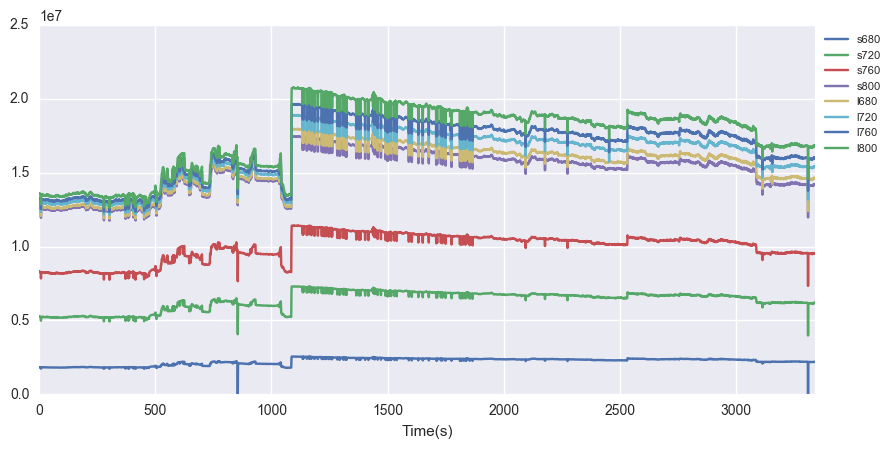

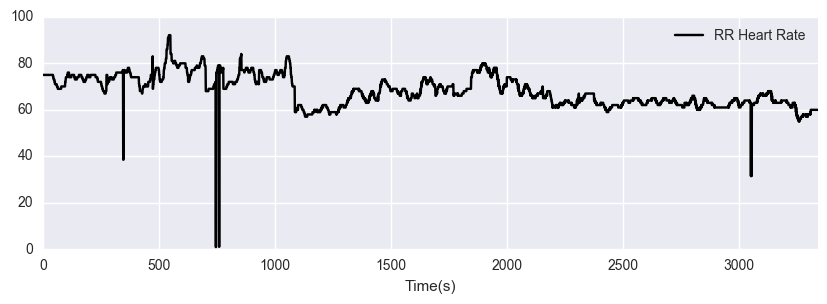

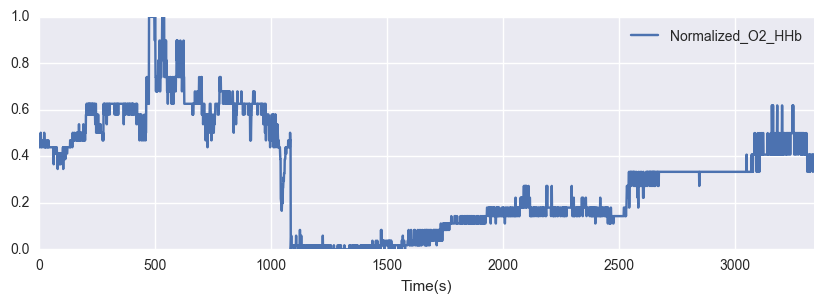

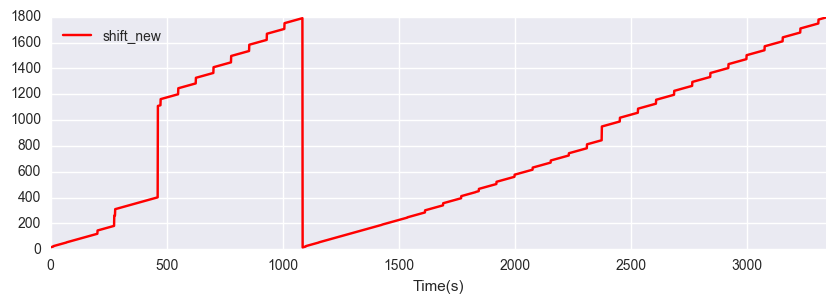

In [61]:
plt.figure()
ax = vertical_stack_new.iloc[:, :8].plot(figsize=(10, 6),legend=True, stacked=True)
# ax = vertical_stack_new.plot(secondary_y=['A', 'B', 'C', 'D'])

# ax.legend(loc='upper right')
plt.legend(loc='upper left', prop={'size':8}, bbox_to_anchor=(1,1))
plt.tight_layout(pad=7)
ax.set_xlabel('Time(s)')
ax = vertical_stack_new.iloc[:, 9:10].plot(figsize=(10, 3),legend=True, stacked=True, color='k')
ax.set_xlabel('Time(s)')

ax = vertical_stack_new.iloc[:, 8:9].plot(figsize=(10, 3),legend=True, stacked=True)
ax.set_xlabel('Time(s)')

ax = vertical_stack_new.iloc[:, 10:11].plot(figsize=(10, 3),legend=True, stacked=True, color='r')
ax.set_xlabel('Time(s)')


# # ax.right_ax.set_ylabel('AB scale')
# ax = vertical_stack_new.iloc[:, 8:].plot(subplots=True, layout=(1, 3), figsize=(10, 3), sharex=True)
# # ax.set_xlabel('Time')


## <h1 align="center"> V. Conclusion </h1>

### Free-Form Visualization

The visualization above shows the relevant problem of the data set - the different features along with the value that is value to predict. The plot overlays each feature, scaled to display all on the same axis with their relevant measures, scaled on the y axis and all plotted according to the same time measurement they were recorded on, on the x axis. 


### Reflection
Our solution was achieved by determining the following:
    1. What were we trying to predict?
    This was our HR value recorded along with our optical data
    2. What do we need to be able to predict this?
    This was the optical data and normalized value we measured and calculated above. 
    3. What methods can we use to train a model to be able to accurately predict this?
    We did this by experimenting with different Machine Learning techniques and measuring their accuracy. A baseline value 
    was determined by information collected about what similar technologies are able to achieve. 
    4. Have we achieved our goal?
    Processing the data and tuning our different algorithms to 


### Improvement
Improvement requires more accurate data. The synchronization problem cripples this experiment, and underscores that the accuracy of a model is best improved by obtaining better data. You can build a mansion on an old landfill, but it will probably explode someday: http://landfill-gas.com/1980s-landfill-gas-explosions.html.
